In [181]:
import pandas as pd
import numpy as np

In [182]:
train_data = pd.read_csv('Train_UWu5bXk.csv')
test_data = pd.read_csv('Test_u94Q5KV.csv')
train_data.head()
test_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


I am combining the data in the train and test in order to perform any feature engineering. This will save time to work changes on both of them together. We can easily split them up ater

In [183]:
train_data['source'] = 'train'
test_data['source'] = 'test'
data = pd.concat([train_data, test_data],ignore_index=True)
print train_data.shape, test_data.shape, data.shape

(8523, 13) (5681, 12) (14204, 13)


Thus we can see that data has same #columns but rows equivalent to both test and train. One of the key challenges in any data set is missing values. Lets start by checking which columns contain missing values.

In [184]:
data.apply(lambda x: sum(x.isnull()))

Item_Fat_Content                0
Item_Identifier                 0
Item_MRP                        0
Item_Outlet_Sales            5681
Item_Type                       0
Item_Visibility                 0
Item_Weight                  2439
Outlet_Establishment_Year       0
Outlet_Identifier               0
Outlet_Location_Type            0
Outlet_Size                  4016
Outlet_Type                     0
source                          0
dtype: int64

Note that the *Item_Outlet_Sales* is the target variable and missing values are ones in the test set. So we need not worry about it. But we’ll impute the missing values in Item_Weight and Outlet_Size in the data cleaning section.

Lets look at some basic statistics for numerical variables.

Exploring which items have more visibility in the store....

In [185]:
data.loc[data['Item_Visibility'] == 0.328391]

,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,source


In [186]:
# List of unique items
data['Item_Type'].unique()

array(['Dairy', 'Soft Drinks', 'Meat', 'Fruits and Vegetables',
       'Household', 'Baking Goods', 'Snack Foods', 'Frozen Foods',
       'Breakfast', 'Health and Hygiene', 'Hard Drinks', 'Canned',
       'Breads', 'Starchy Foods', 'Others', 'Seafood'], dtype=object)

### Some observations:

1. Item_Visibility has a min value of zero. This makes no practical sense because when a product is being sold in a store, the visibility cannot be 0.

2. Outlet_Establishment_Years vary from 1985 to 2009. The values might not be apt in this form. Rather, if we can convert them to how old the particular store is, it should have a better impact on sales.

3. The lower ‘count’ of Item_Weight and Item_Outlet_Sales confirms the findings from the missing value check.
   Moving to nominal (categorical) variable, lets have a look at the number of unique values in each of them.

In [187]:
data.apply(lambda x: len(x.unique()))

Item_Fat_Content                 5
Item_Identifier               1559
Item_MRP                      8052
Item_Outlet_Sales             3494
Item_Type                       16
Item_Visibility              13006
Item_Weight                    416
Outlet_Establishment_Year        9
Outlet_Identifier               10
Outlet_Location_Type             3
Outlet_Size                      4
Outlet_Type                      4
source                           2
dtype: int64

This tells us that there are **1559 products and 10 outlets/stores** (which was also mentioned in problem statement). Another thing that should catch attention is that Item_Type has 16 unique values. Let’s explore further using the frequency of different categories in each nominal variable. I’ll exclude the ID and source variables for obvious reasons.

In [188]:
# Filter categorical variables
categorical_columns = [x for x in data.dtypes.index if data.dtypes[x] == 'object']

#Exclude ID cols and source
categorical_columns = [x for x in categorical_columns if x not in ['Item_Identifier','Outlet_Identifier','source']]

#Print the categories column
for col in categorical_columns:
    print '\n Frequency of Categories for variables %s'%col
    print data[col].value_counts()


 Frequency of Categories for variables Item_Fat_Content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

 Frequency of Categories for variables Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

 Frequency of Categories for variables Outlet_Location_Type
Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64

 Frequency of Categories for variables Outlet_Size
Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dty

The output gives us following observations:

1. **Item_Fat_Content:** Some of ‘Low Fat’ values mis-coded as ‘low fat’ and ‘LF’. Also, some of ‘Regular’ are mentioned as ‘regular’.

2. **Item_Type:** Not all categories have substantial numbers. It looks like combining them can give better results.

3.** Outlet_Type:** Supermarket Type2 and Type3 can be combined. But we should check if that’s a good idea before doing it.

## 3. Data Cleaning

#### Inputing missing values

We found 2 missing values in our data – Item_Weight and Outlet_Size. Lets impute the former by the average weight of the particular item. This can be done as:

In [189]:
# Determine the average weight per item:
item_average_weight = data.pivot_table(values = 'Item_Weight', index='Item_Identifier')
item_average_weight[:5]

#get a Boolean variable for specifying missing Item_weight values
miss_bool = data['Item_Weight'].isnull()
miss_bool[:5]

#Impute data and check the missing values before and after imputation to confirm
print 'Original missing item weight: %d' %sum(miss_bool)

data.loc[miss_bool,'Item_Weight'] = data.loc[miss_bool,'Item_Identifier'].apply(lambda x: item_average_weight[x])

print 'final missing Item_Weights: %d' %sum(data['Item_Weight'].isnull())


Original missing item weight: 2439
final missing Item_Weights: 0


This confirms that the column has no missing values now. Lets impute Outlet_Size with the mode of the Outlet_Size for the particular type of outlet.

In [190]:
from scipy.stats import mode

#Determine the mode for outlet type
outlet_size_mode = data.pivot_table(values='Outlet_Size', columns='Outlet_Type',aggfunc=(lambda x:mode(x).mode[0]) )
print 'Mode for each Outlet_Type:'
print outlet_size_mode

#Boolean values for missing Outlet_Size
miss_bool = data['Outlet_Size'].isnull()

# Impute data and check missing values

print '\nOrignal #missing: %d'% sum(miss_bool)

data.loc[miss_bool,'Outlet_Size'] = data.loc[miss_bool,'Outlet_Type'].apply(lambda x: outlet_size_mode[x])

print sum(data['Outlet_Size'].isnull())


Mode for each Outlet_Type:
Outlet_Type
Grocery Store         Small
Supermarket Type1     Small
Supermarket Type2    Medium
Supermarket Type3    Medium
Name: Outlet_Size, dtype: object

Orignal #missing: 4016
0


## 4. Feature Engineering

We explored some nuances in the data in the data exploration phase. Lets move on to resolving them and making our data ready for analysis. We will also create some new variables using the existing ones in this section.

In [191]:
data.pivot_table(values='Item_Outlet_Sales', index='Outlet_Type')


Outlet_Type
Grocery Store         339.828500
Supermarket Type1    2316.181148
Supermarket Type2    1995.498739
Supermarket Type3    3694.038558
Name: Item_Outlet_Sales, dtype: float64

I decided to keep them as it is as there is significance difference between the different Outlet_types

### step 2. Modify Item_Visibility

We noticed that the minimum value here is 0, which makes no practical sense. Lets consider it like missing information and impute it with mean visibility of that product.

In [192]:
#Determine average visibility of a product
visibility_avg = data.pivot_table(values='Item_Visibility', index='Item_Identifier')

#Impute 0 values with mean visibility of that product:
miss_bool1 = (data['Item_Visibility'] == 0)

print 'Number of 0 values initially: %d'%sum(miss_bool1)
data.loc[miss_bool1,'Item_Visibility'] = data.loc[miss_bool1,'Item_Identifier'].apply(lambda x: visibility_avg[x])
print 'Number of 0 values after modification: %d'%sum(data['Item_Visibility'] == 0)

Number of 0 values initially: 879
Number of 0 values after modification: 0


In [193]:
#Determine another variable with means ratio
data['Item_Visibility_MeanRatio'] = data.apply(lambda x: x['Item_Visibility']/visibility_avg[x['Item_Identifier']], axis=1)
print data['Item_Visibility_MeanRatio'].describe()

count    14204.000000
mean         1.061884
std          0.235907
min          0.844563
25%          0.925131
50%          0.999070
75%          1.042007
max          3.010094
Name: Item_Visibility_MeanRatio, dtype: float64


### Step 3: Create a broad category of Type of Item

Earlier we saw that the Item_Type variable has 16 categories which might prove to be very useful in analysis. So its a good idea to combine them. One way could be to manually assign a new category to each. But there’s a catch here. If you look at the Item_Identifier, i.e. the unique ID of each item, it starts with either FD, DR or NC. If you see the categories, these look like being Food, Drinks and Non-Consumables. So I’ve used the Item_Identifier variable to create a new column:

In [194]:
data['Item_Type'].value_counts()

Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

We want to combine these together using the Item Identifier - FD, NC and DR

In [195]:
data['Item_Type_Combined'] = data['Item_Identifier'].apply(lambda x: x[:2])
print data['Item_Type_Combined'][:5]

# Rename to more intuitve name
data['Item_Type_Combined'] = data['Item_Type_Combined'].map({'FD': 'Food',
                                                        'NC': 'Non-Consumables',
                                                        'DR': 'Drinks'})
print data['Item_Type_Combined'][:5]

data['Item_Type_Combined'].value_counts()

0    FD
1    DR
2    FD
3    FD
4    NC
Name: Item_Type_Combined, dtype: object
0               Food
1             Drinks
2               Food
3               Food
4    Non-Consumables
Name: Item_Type_Combined, dtype: object


Food               10201
Non-Consumables     2686
Drinks              1317
Name: Item_Type_Combined, dtype: int64

### Step 4. Years of Operations of store

We want to make a new operation depicting the years of operations of the store


#Years:
data['Outlet_Years'] = 2013 - data['Outlet_Establishment_Year']
data['Outlet_Years'].describe()

### Step 5: Modify categories of Item_Fat_Content

In [196]:
# Change the caegories of fat item
print 'Original Categories:'
print data['Item_Fat_Content'].value_counts()

# we need only 2 categories here Low fat and Regular
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF':'Low Fat',
                                                             'reg':'Regular',
                                                             'low fat':'Low Fat'})
print 'New Categories:'
print data['Item_Fat_Content'].value_counts()

Original Categories:
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64
New Categories:
Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64


In [197]:
data['Item_Fat_Content'].describe()

count       14204
unique          2
top       Low Fat
freq         9185
Name: Item_Fat_Content, dtype: object

Now it makes more sense. But hang on, in step 4 we saw there were some non-consumables as well and a fat-content should not be specified for them. So we can also create a separate category for such kind of observations.

In [198]:
#Mark non-consumables as separate category in low_fat:
data.loc[data['Item_Type_Combined']=="Non-Consumables",'Item_Fat_Content'] = "Non-Edible"
data['Item_Fat_Content'].value_counts()

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64

### Step 6: Numerical and One-Hot Coding of Categorical variables

Since scikit-learn accepts only numerical variables, I converted all categories of nominal variables into numeric types. Also, I wanted Outlet_Identifier as a variable as well. So I created a new variable ‘Outlet’ same as Outlet_Identifier and coded that. Outlet_Identifier should remain as it is, because it will be required in the submission file.

Lets start with coding all categorical variables as numeric using ‘LabelEncoder’ from sklearn’s preprocessing module.


In [199]:
# Import library
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
#New variable for Outlet
data['Outlet'] = le.fit_transform(data['Outlet_Identifier'])

var_mod = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Type_Combined','Outlet_Type','Outlet']

le = LabelEncoder()

for i in var_mod:
    data[i] = le.fit_transform(data[i])


One-Hot-Coding refers to creating dummy variables, one for each category of a categorical variable. For example, the Item_Fat_Content has 3 categories – ‘Low Fat’, ‘Regular’ and ‘Non-Edible’. One hot coding will remove this variable and generate 3 new variables. Each will have binary numbers – 0 (if the category is not present) and 1(if category is present). This can be done using ‘get_dummies’ function of Pandas.

In [200]:
#One Hot Coding:
data = pd.get_dummies(data, columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type',
                              'Item_Type_Combined','Outlet'])

Lets look at the datatypes of columns now:

In [201]:
data.dtypes

Item_Identifier               object
Item_MRP                     float64
Item_Outlet_Sales            float64
Item_Type                     object
Item_Visibility              float64
Item_Weight                  float64
Outlet_Establishment_Year      int64
Outlet_Identifier             object
source                        object
Item_Visibility_MeanRatio    float64
Item_Fat_Content_0           float64
Item_Fat_Content_1           float64
Item_Fat_Content_2           float64
Outlet_Location_Type_0       float64
Outlet_Location_Type_1       float64
Outlet_Location_Type_2       float64
Outlet_Size_0                float64
Outlet_Size_1                float64
Outlet_Size_2                float64
Outlet_Type_0                float64
Outlet_Type_1                float64
Outlet_Type_2                float64
Outlet_Type_3                float64
Item_Type_Combined_0         float64
Item_Type_Combined_1         float64
Item_Type_Combined_2         float64
Outlet_0                     float64
O

Here we can see that all variables are now float and each category has a new variable. Lets look at the 3 columns formed from Item_Fat_Content.

In [202]:
data[['Item_Fat_Content_0','Item_Fat_Content_1','Item_Fat_Content_2']].head(10)

,Item_Fat_Content_0,Item_Fat_Content_1,Item_Fat_Content_2
0,1.0,0.0,0.0
1,0.0,0.0,1.0
2,1.0,0.0,0.0
3,0.0,0.0,1.0
4,0.0,1.0,0.0
5,0.0,0.0,1.0
6,0.0,0.0,1.0
7,1.0,0.0,0.0
8,0.0,0.0,1.0
9,0.0,0.0,1.0


You can notice that each row will have only one of the columns as 1 corresponding to the category in the original variable.

### Step 7: Exporting Data

Final step is to convert data back into train and test data sets. Its generally a good idea to export both of these as modified data sets so that they can be re-used for multiple sessions. This can be achieved using following code:

In [203]:
#Drop the columns which have been converted to different types:
data.drop(['Item_Type','Outlet_Establishment_Year'],axis=1,inplace=True)

#Divide into test and train:
train = data.loc[data['source']=="train"]
test = data.loc[data['source']=="test"]

#Drop unnecessary columns:
test.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)
train.drop(['source'],axis=1,inplace=True)

#Export files as modified versions:
train.to_csv("train_modified.csv",index=False)
test.to_csv("test_modified.csv",index=False)

C:\Users\PrasadPagade\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\PrasadPagade\Anaconda2\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## 4. Model Building

Now that we have the data ready, its time to start making predictive models. I will take you through 6 models including linear regression, decision tree and random forest which can get you into Top 20 ranks in this competition (I mean ranks as of today because after reading this article, I’m sure many new leaders will emerge).

Lets start by making a baseline model. Baseline model is the one which requires no predictive model and its like an informed guess. For instance, in this case lets predict the sales as the overall average sales. This can be done as:

In [204]:
# Mean Based
mean_sales = train['Item_Outlet_Sales'].mean()
print mean_sales

#Define a dataframe with IDs for submission:
base1 = test[['Item_Identifier','Outlet_Identifier']]
base1['Item_Outlet_Sales'] = mean_sales

#Export submission file
base1.to_csv("alg0.csv",index=False)

2181.28891358


C:\Users\PrasadPagade\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Now, time for some actual predictive models. Let's create a function which takes the **algorithm and data** as input and makes the **model, performs cross-validation and generates submission**.

In [205]:
#Define target and ID columns:
target = 'Item_Outlet_Sales'
IDcol = ['Item_Identifier','Outlet_Identifier']
from sklearn import cross_validation, metrics
def modelfit(alg, dtrain, dtest, predictors, target, IDcol, filename):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])

    #Perform cross-validation:
    cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain[target], cv=20, scoring='neg_mean_squared_error')
    cv_score = np.sqrt(np.abs(cv_score))
    
    #Print model report:
    print "\nModel Report"
    print "RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(dtrain[target].values, dtrain_predictions))
    print "CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
    
    #Predict on testing data:
    dtest[target] = alg.predict(dtest[predictors])
    
    #Export submission file:
    IDcol.append(target)
    submission = pd.DataFrame({ x: dtest[x] for x in IDcol})
    submission.to_csv(filename, index=False)

## Ridge Regression Model:


Model Report
RMSE : 1129
CV Score : Mean - 1130 | Std - 44.61 | Min - 1075 | Max - 1217


C:\Users\PrasadPagade\Anaconda2\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


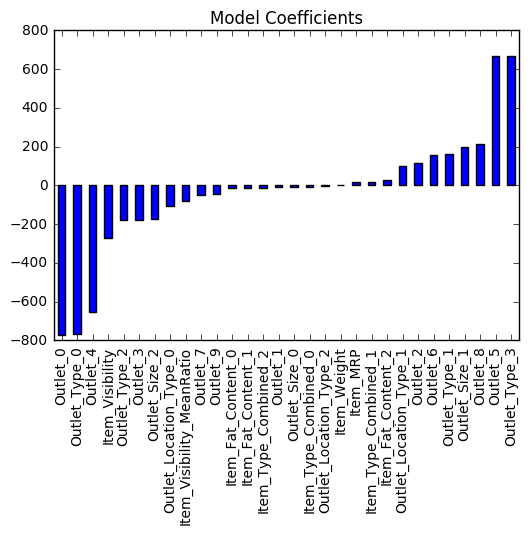

In [206]:
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg2 = Ridge(alpha=0.05,normalize=True)
modelfit(alg2, train, test, predictors, target, IDcol, 'alg2.csv')
coef2 = pd.Series(alg2.coef_, predictors).sort_values()
coef2.plot(kind='bar', title='Model Coefficients')

## Decision Tree Model

Lets try out a decision tree model and see if we get something better.


Model Report
RMSE : 1058
CV Score : Mean - 1091 | Std - 44.44 | Min - 1006 | Max - 1184


C:\Users\PrasadPagade\Anaconda2\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


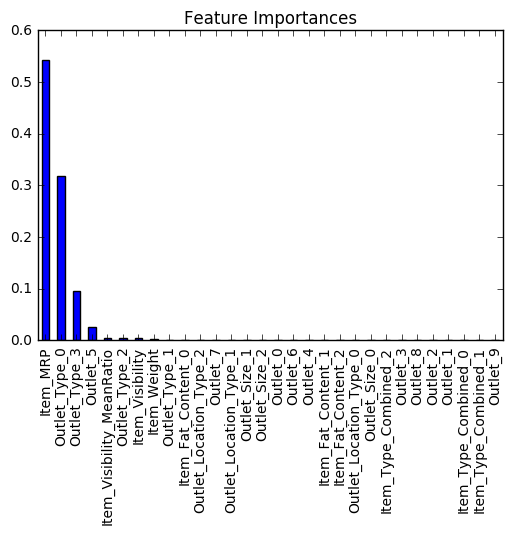

In [207]:
from sklearn.tree import DecisionTreeRegressor
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg3 = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)
modelfit(alg3, train, test, predictors, target, IDcol, 'alg3.csv')
coef3 = pd.Series(alg3.feature_importances_, predictors).sort_values(ascending=False)
coef3.plot(kind='bar', title='Feature Importances')

### Random Forest Model

Lets try a random forest model as well and see if we get some improvements.


Model Report
RMSE : 1074
CV Score : Mean - 1084 | Std - 43.6 | Min - 1021 | Max - 1164


C:\Users\PrasadPagade\Anaconda2\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


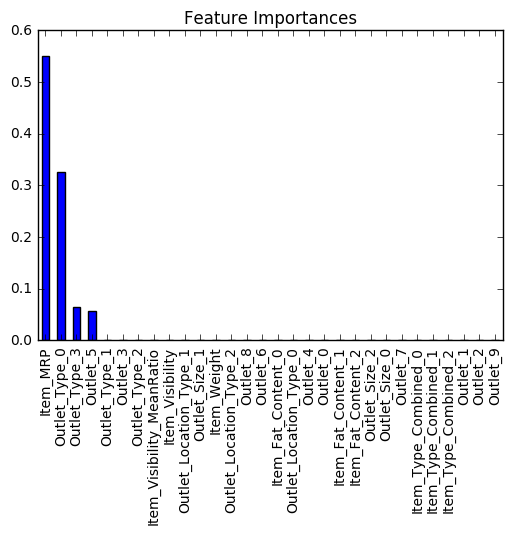

In [209]:
from sklearn.ensemble import RandomForestRegressor
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg5 = RandomForestRegressor(n_estimators=200,max_depth=5, min_samples_leaf=100,n_jobs=4)
modelfit(alg5, train, test, predictors, target, IDcol, 'alg5.csv')
coef5 = pd.Series(alg5.feature_importances_, predictors).sort_values(ascending=False)
coef5.plot(kind='bar', title='Feature Importances')